In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("D:\YUKTA\Assignment\DS\Timeseries\exchange_rate.csv")

In [3]:
data.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


# EDA:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [5]:
data.shape

(7588, 2)

In [6]:
data.isnull().sum()

date       0
Ex_rate    0
dtype: int64

**The data has no missing values.**

**Plotting the time series data:**

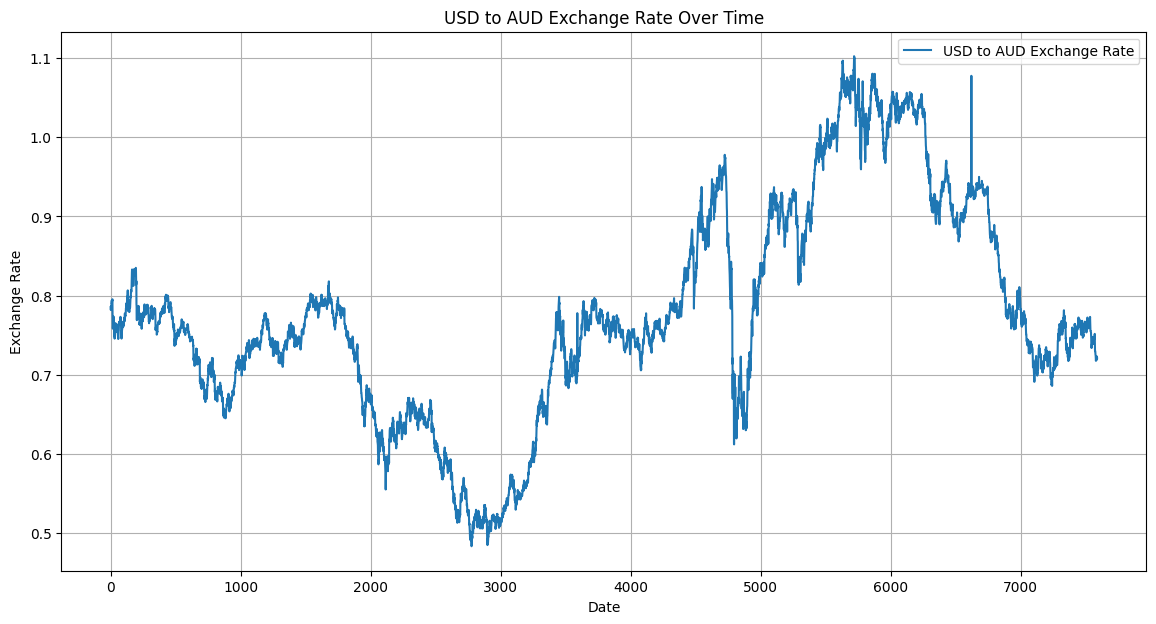

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

The data shows a decreasing trend followed by an increasing trend which gradually decreases again.

**So we can say that it follows a cyclic or seasonal pattern.**

# Model Building - ARIMA:

In [8]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

**Plot ACF and PACF:**

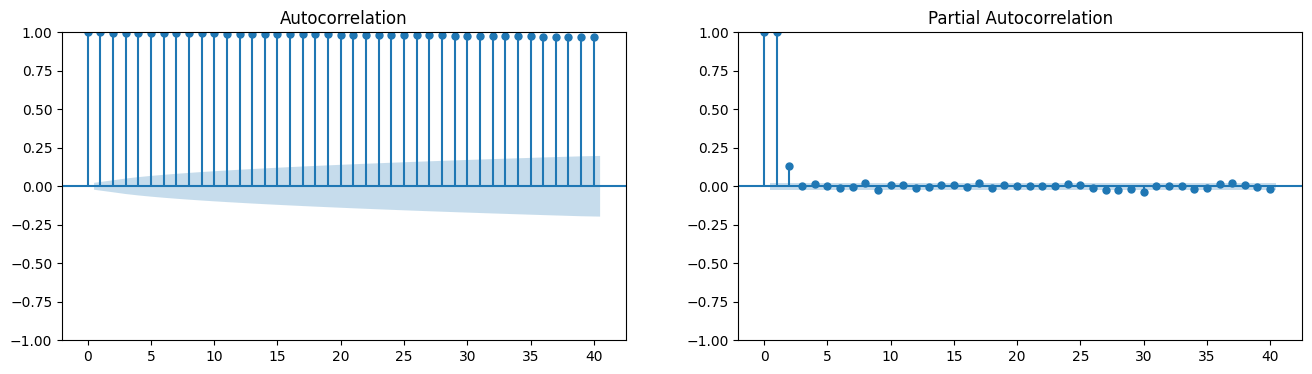

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['Ex_rate'], lags=40, ax=axes[0])
plot_pacf(data['Ex_rate'], lags=40, ax=axes[1])
plt.show()

**Fit the ARIMA model:**

In [10]:
model = ARIMA(data['Ex_rate'], order=(1, 1, 1))
fitted_model = model.fit()

In [11]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 23 Jul 2024   AIC                         -56102.322
Time:                        16:55:54   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.608      0.0

1) The ARIMA(1, 1, 1) model seems to fit the data well, as indicated by the log likelihood and information criteria (AIC, BIC, HQIC).
2) The low values of AIC, BIC, and HQIC suggest that the model is effective in capturing the data's structure.

In [12]:
forecast_steps = 250  # Number of steps to forecast
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame()

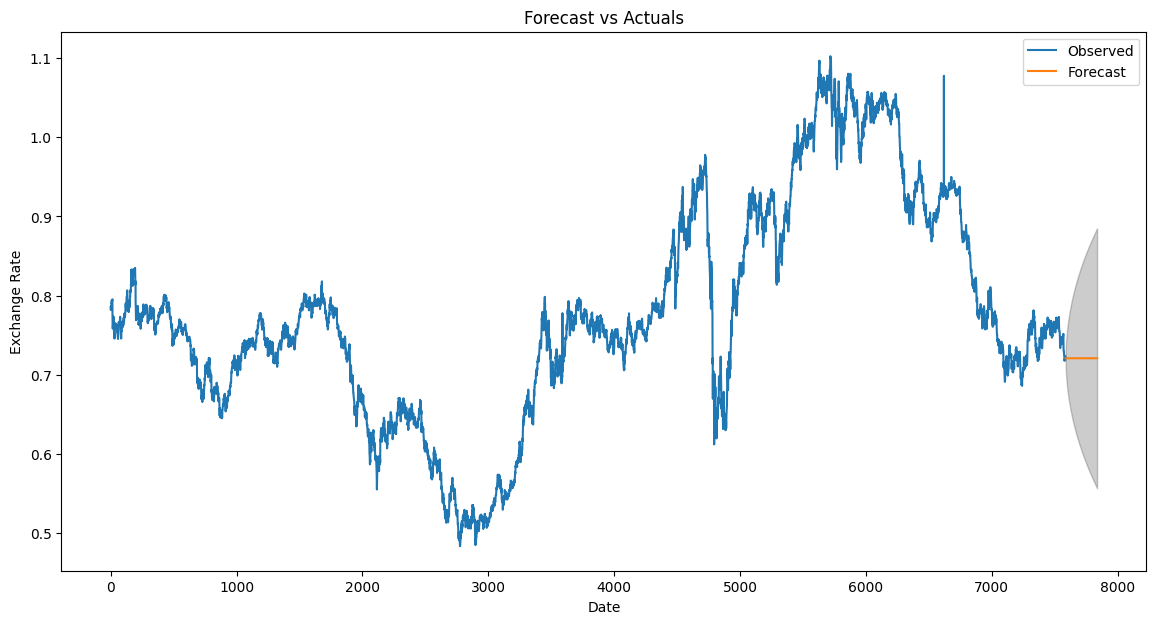

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Ex_rate'], label='Observed')
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='k', alpha=0.2)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Model Building - Exponential Smoothing:

**Simple exponential model:**

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [15]:
# Fit the model
ses_model = SimpleExpSmoothing(data['Ex_rate']).fit()

In [16]:
# Forecast
ses_forecast = ses_model.forecast(steps=250)

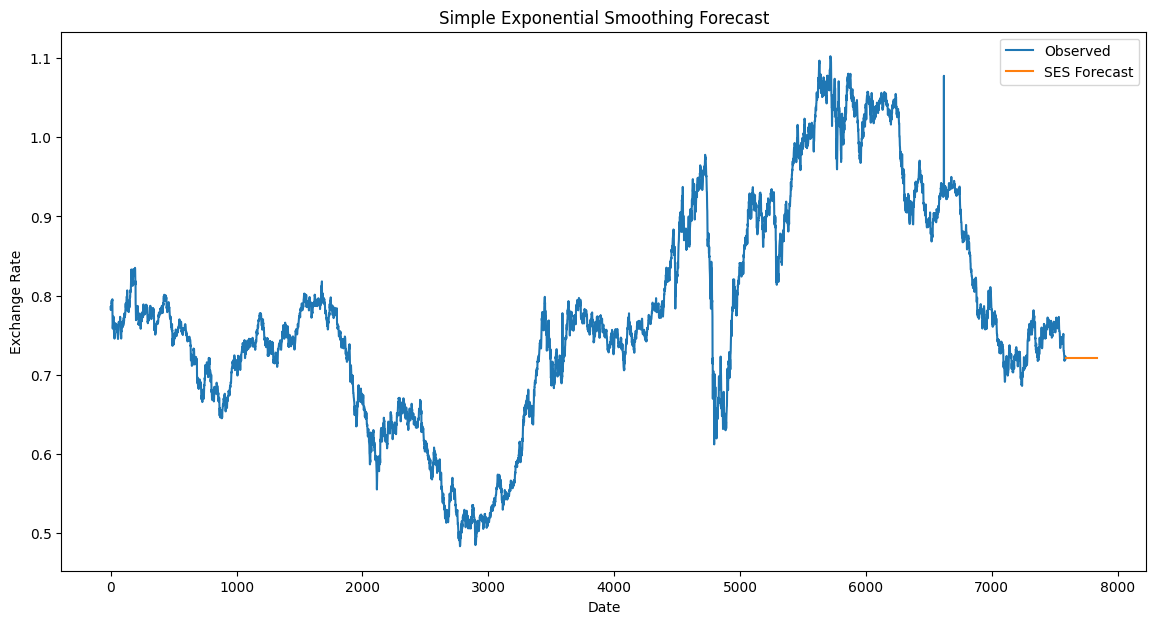

In [17]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Ex_rate'], label='Observed')
plt.plot(ses_forecast.index, ses_forecast, label='SES Forecast')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

**Holt’s Linear Trend Model:**

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [19]:
# Fit the model
holt_model = ExponentialSmoothing(data['Ex_rate'], trend='add', seasonal=None, seasonal_periods=None).fit()

In [20]:
# Forecast
holt_forecast = holt_model.forecast(steps=250)

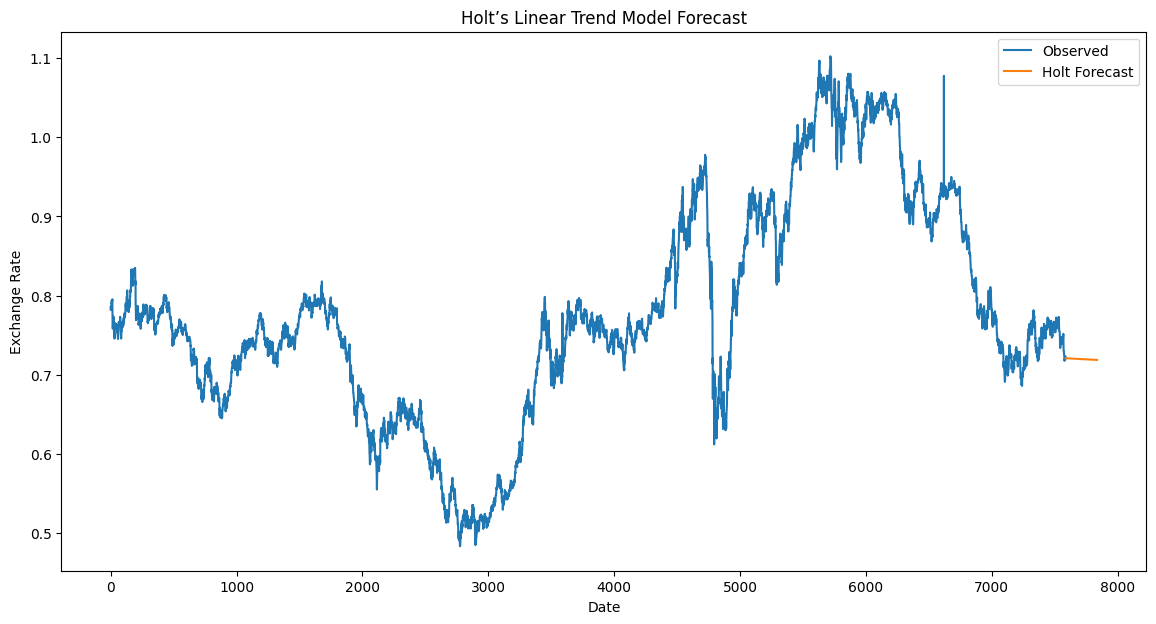

In [21]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Ex_rate'], label='Observed')
plt.plot(holt_forecast.index, holt_forecast, label='Holt Forecast')
plt.title('Holt’s Linear Trend Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

**Holt-Winters Seasonal Model:**

In [22]:
hw_model = ExponentialSmoothing(data['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12).fit()

In [23]:
# Forecast
hw_forecast = hw_model.forecast(steps=250)

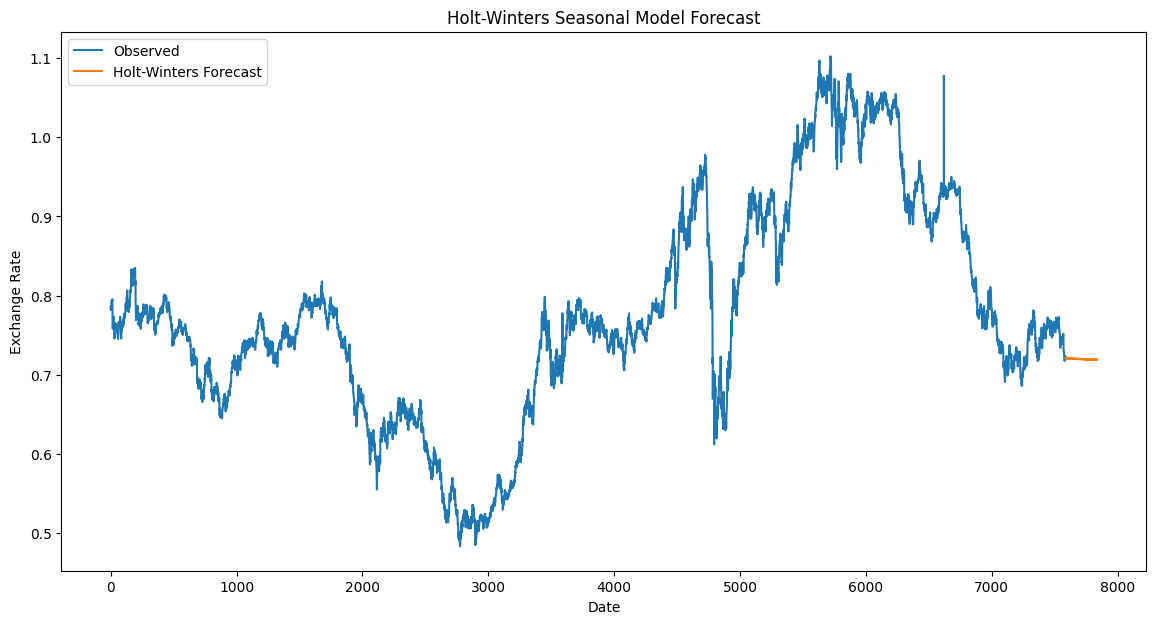

In [24]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Ex_rate'], label='Observed')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast')
plt.title('Holt-Winters Seasonal Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

**Parameter Optimization:**

In [25]:
import itertools

In [26]:
# Define the parameter grid
trend_options = ['add', 'mul', None]
damped_options = [True, False]
seasonal_options = ['add', 'mul', None]
seasonal_periods = [None, 12]

In [27]:
param_grid = list(itertools.product(trend_options, damped_options, seasonal_options, seasonal_periods))

In [28]:
best_aic = np.inf
best_params = None
best_model = None

In [29]:
# Grid search
for trend, damped, seasonal, seasonal_period in param_grid:
    try:
        model = ExponentialSmoothing(data['Ex_rate'], trend=trend, damped_trend=damped, seasonal=seasonal, seasonal_periods=seasonal_period)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_params = (trend, damped, seasonal, seasonal_period)
            best_model = model_fit
    except:
        continue

print('Best AIC:', best_aic)
print('Best Parameters:', best_params)

C:\Users\yukta\.conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\yukta\.conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best AIC: -77644.98075015451
Best Parameters: (None, False, None, None)


This suggests that a **Simple Exponential Smoothing (SES) model**, which does not include trend or seasonality components, is the most appropriate for your time series data based on the AIC criterion.

**Fitting the best model (SES):**

In [30]:
best_model = SimpleExpSmoothing(data['Ex_rate']).fit()

In [31]:
forecast_steps = 250
best_forecast = best_model.forecast(steps=forecast_steps)

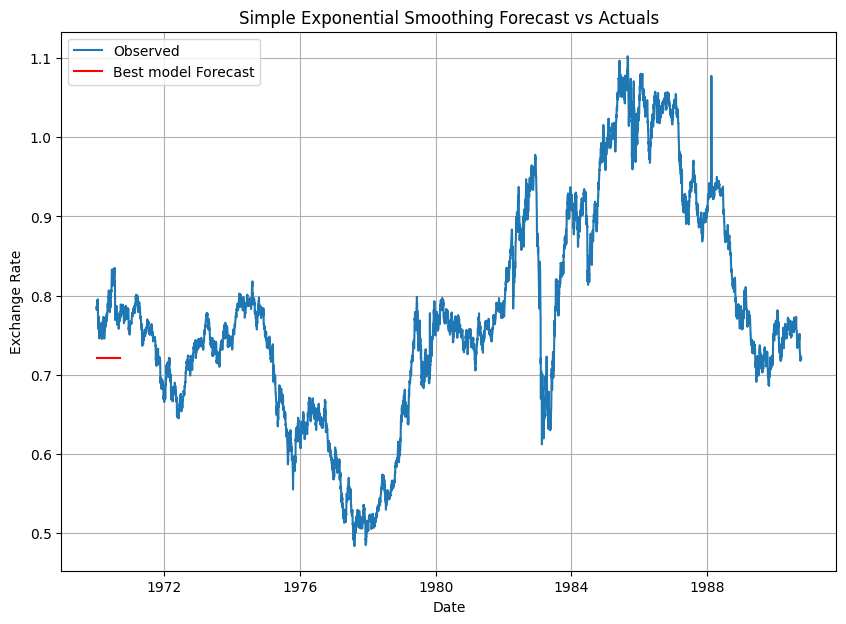

In [32]:
# Plot the results
plt.figure(figsize=(10, 7))
plt.plot(data.index, data['Ex_rate'], label='Observed')
plt.plot(pd.date_range(start=data.index[-1], periods=forecast_steps, freq='D'), best_forecast, label='Best model Forecast', color='red')
plt.title('Simple Exponential Smoothing Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation and Comparison:

**Error Metrics for ARIMA Model:**

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [34]:
arima_model = ARIMA(data['Ex_rate'], order=(1, 1, 1)).fit()
arima_in_sample = arima_model.predict(start=1, end=len(data)-1, typ='levels')

In [35]:
arima_mae = mean_absolute_error(data['Ex_rate'][1:], arima_in_sample)
arima_rmse = np.sqrt(mean_squared_error(data['Ex_rate'][1:], arima_in_sample))
arima_mape = np.mean(np.abs((data['Ex_rate'][1:] - arima_in_sample) / data['Ex_rate'][1:])) * 100

In [36]:
print(f"ARIMA Model -\n MAE: {arima_mae}\n RMSE: {arima_rmse}\n MAPE: {arima_mape}")

ARIMA Model -
 MAE: 0.0036928396107890663
 RMSE: 0.005996369074544927
 MAPE: 0.4820202409571639


**Error Metrics for SES model:**

In [37]:
ses_in_sample = best_model.fittedvalues

In [38]:
ses_mae = mean_absolute_error(data['Ex_rate'], ses_in_sample)
ses_rmse = np.sqrt(mean_squared_error(data['Ex_rate'], ses_in_sample))
ses_mape = np.mean(np.abs((data['Ex_rate'] - ses_in_sample) / data['Ex_rate'])) * 100

In [39]:
print(f"SES Model -\n MAE: {ses_mae}\n RMSE: {ses_rmse}\n MAPE: {ses_mape}")

SES Model -
 MAE: 0.0036929728716299285
 RMSE: 0.00599659469996141
 MAPE: 0.4820116319634634


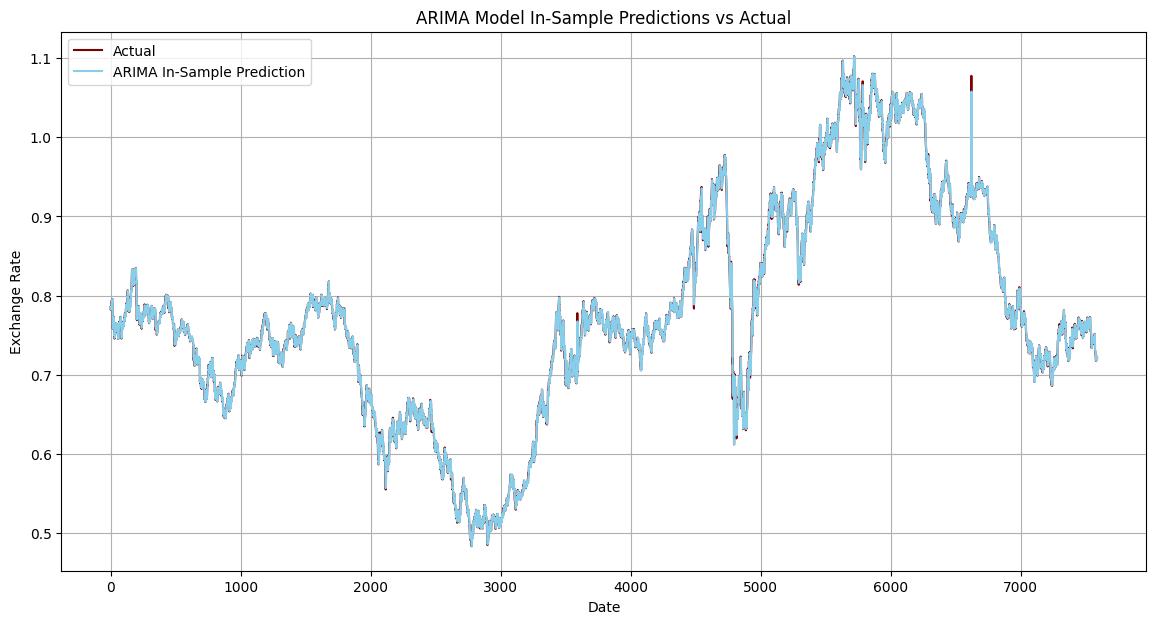

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Ex_rate'], label='Actual', color='maroon')
plt.plot(data.index[1:], arima_in_sample, label='ARIMA In-Sample Prediction', color='skyblue')
plt.title('ARIMA Model In-Sample Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

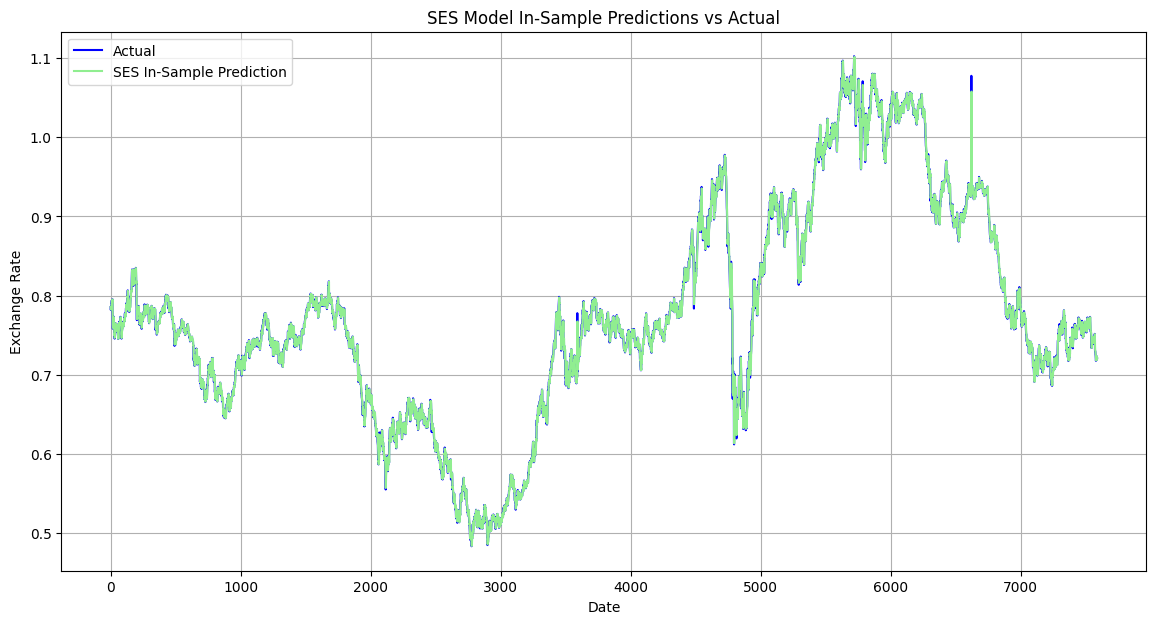

In [41]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Ex_rate'], label='Actual', color='blue')
plt.plot(data.index, ses_in_sample, label='SES In-Sample Prediction', color='lightgreen')
plt.title('SES Model In-Sample Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion:

In [42]:
print(f"ARIMA Model -\n MAE: {arima_mae}\n RMSE: {arima_rmse}\n MAPE: {arima_mape}\n\n")
print(f"SES Model -\n MAE: {ses_mae}\n RMSE: {ses_rmse}\n MAPE: {ses_mape}")

if arima_rmse < ses_rmse:
    best_model = 'ARIMA'
else:
    best_model = 'SES'

print(f"\n\nBased on the RMSE, the {best_model} model yielded the best performance for forecasting exchange rates in this dataset.")

ARIMA Model -
 MAE: 0.0036928396107890663
 RMSE: 0.005996369074544927
 MAPE: 0.4820202409571639


SES Model -
 MAE: 0.0036929728716299285
 RMSE: 0.00599659469996141
 MAPE: 0.4820116319634634


Based on the RMSE, the ARIMA model yielded the best performance for forecasting exchange rates in this dataset.
